In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

/var/folders/08/7v7yqd7n0y5cznq8k2_1s6v40000gn/T/ipykernel_85092/2076538094.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# MNIST 데이터셋 다운로드 (1분 가량 소요)
mnist = datasets.fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist.data, mnist.target
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [4]:
# 이진 분류용 훈련 데이터 준비
def prepare_binary_classification_data(X, y, label1, label2):
    binary_index = (y == label1) | (y == label2)
    X_binary = X[binary_index]
    y_binary = y[binary_index]
    y_map = {label1: -1, label2: 1}
    y_binary = np.array([y_map[label] for label in y_binary])
    return X_binary, y_binary

X_train_binary, y_train_binary = prepare_binary_classification_data(X_train, y_train, 3, 5)
X_test_binary, y_test_binary = prepare_binary_classification_data(X_test, y_test, 3, 5)

X_train_binary.shape, X_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((10763, 784), (2691, 784), (10763,), (2691,))

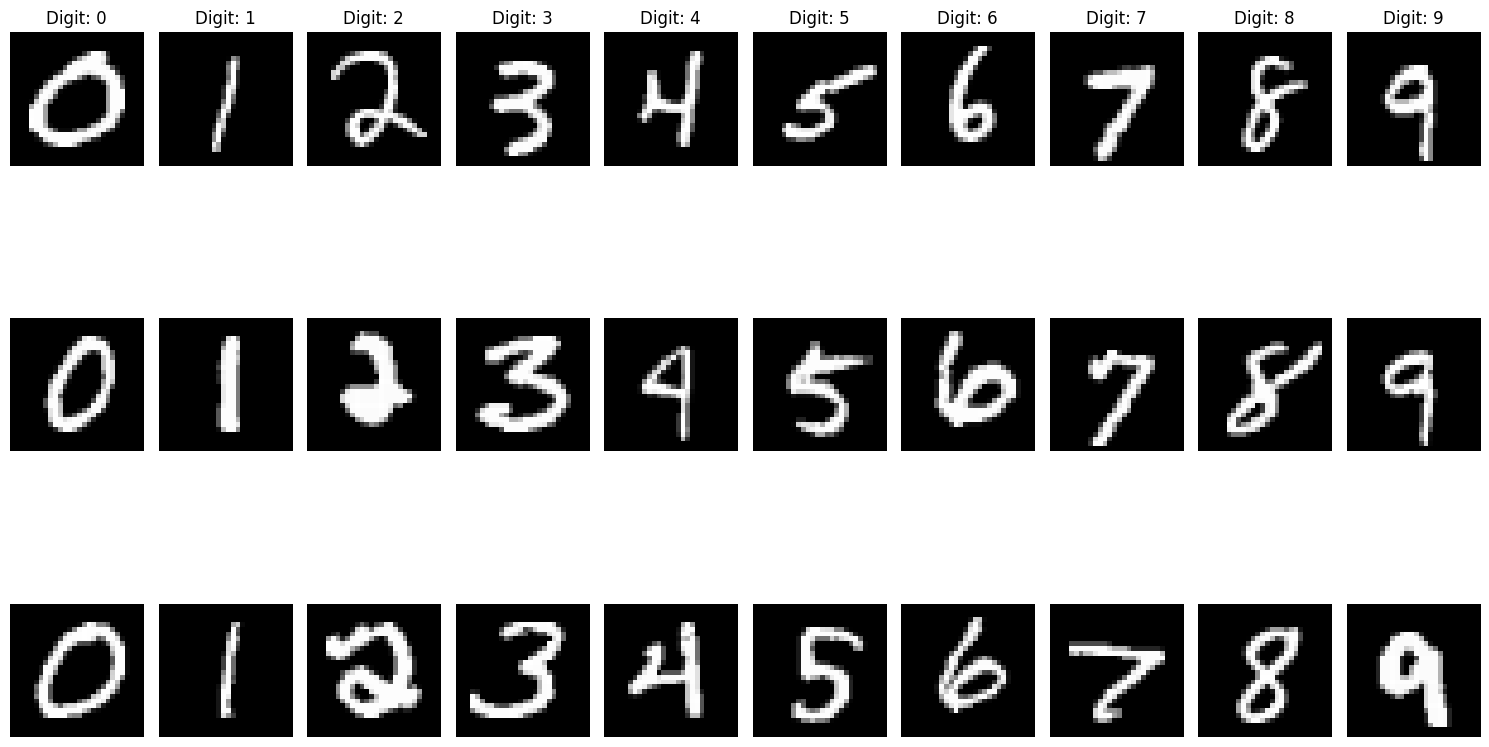

In [5]:
# 데이터 시각화 
n_classes = 10
n_samples_per_class = 3
samples_per_class = {i: [] for i in range(n_classes)}

for digit in range(n_classes):
    digit_indices = np.where(y == digit)[0]
    selected_indices = np.random.choice(digit_indices, n_samples_per_class, replace=False)
    samples_per_class[digit] = selected_indices

plt.figure(figsize=(15, 10))
for digit in range(n_classes):
    for i in range(n_samples_per_class):
        idx = samples_per_class[digit][i]
        
        plt.subplot(n_samples_per_class, n_classes, i * n_classes + digit + 1)
        plt.imshow(X.iloc[idx].values.reshape(28, 28), cmap='gray')
        if i == 0:
            plt.title(f"Digit: {digit}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## 1. SVM from scratch

fit 함수의 가중치 업데이트 부분을 채워주세요! 가중치 업데이트 이외의 코드는 수정하면 안됩니다.

조건: 분류 정확도 0.9 이상

참고자료: https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

In [6]:
class SVMClassifier:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        # 이 부분은 수정하시면 안됩니다.
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.label_map = None
        self.inverse_label_map = None

    def fit(self, X, y):
        # 이 부분은 수정하시면 안됩니다.
        unique_labels = np.unique(y)
        if len(unique_labels) != 2:
            raise ValueError("This SVM implementation supports only binary classification.")

        self.label_map = {unique_labels[0]: -1, unique_labels[1]: 1}
        self.inverse_label_map = {-1: unique_labels[0], 1: unique_labels[1]}
        
        y_ = np.array([self.label_map[label] for label in y])
        
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0


        # 이 부분을 채워주세요.
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    # condition이 거짓일 때: Regularization + Loss term 반영
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.learning_rate * y_[idx]


    def predict(self, X):
        # 예측값은 wx + b의 부호로 결정됨
        linear_output = np.dot(X, self.w) + self.b
        predictions = np.sign(linear_output)
        return np.array([self.inverse_label_map[pred] for pred in predictions])

In [7]:
svm = SVMClassifier()

fit_start = time.time()
svm.fit(X_train_binary, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_binary)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.494611668524712
Fitting time: 36.087735652923584 seconds
Prediction Time: 0.005795001983642578 seconds


## 2. Dimensionality Reduction

PCA와 LDA를 활용하여 데이터 차원을 축소한 뒤, 모델 학습을 진행해주세요!

PCA 적용하기

In [8]:
from sklearn.decomposition import PCA

# PCA를 사용하여 X_train_binary의 차원을 축소해주세요.

pca = PCA(n_components=10)  # PCA 객체를 생성
X_train_pca = pca.fit_transform(X_train_binary)  # X_train_binary에 PCA 적용
X_test_pca = pca.transform(X_test_binary)  # X_test_binary에도 PCA 적용

print(X_train_pca.shape, X_test_pca.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_pca, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_pca)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 10) (2691, 10)
Accuracy: 0.4693422519509476
Fitting time: 27.417881965637207 seconds
Prediction Time: 0.00033593177795410156 seconds


LDA 적용하기

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train_binary, y_train_binary)
X_test_lda = lda.transform(X_test_binary)


print(X_train_lda.shape, X_test_lda.shape)

svm = SVMClassifier()
fit_start = time.time()
svm.fit(X_train_lda, y_train_binary)
fit_end = time.time()

pred_start = time.time()
pred = svm.predict(X_test_lda)
pred_end = time.time()

print(f"Accuracy: {accuracy_score(y_test_binary, pred)}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

(10763, 1) (2691, 1)
Accuracy: 0.46859903381642515
Fitting time: 31.63595199584961 seconds
Prediction Time: 0.0002486705780029297 seconds


## 3. Multiclass SVM

OvO (One vs One) 방법론을 사용하여 Multiclass svm classifier를 구현해주세요!

In [10]:
# 학습 효율성을 위해 데이터셋의 일부만 사용
mnist_df = pd.concat([mnist.data, mnist.target], axis=1)
mnist_df = mnist_df.groupby('class').apply(lambda x: x.sample(frac=0.01, random_state=42)).reset_index(drop=True)

X, y = mnist_df.drop('class', axis=1), mnist_df['class']
y = y.apply(int)

# 데이터 분할 및 스케일링
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 784), (140, 784), (560,), (140,))

In [11]:
y_train.unique()

[9, 6, 1, 3, 7, 5, 8, 2, 4, 0]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [12]:
import numpy as np
import time
from collections import defaultdict

class OneVsRestSVM:
    def __init__(self, base_classifier):
        self.base_classifier = base_classifier
        self.classifiers = defaultdict()

    def fit(self, X, y):
        self.unique_classes = np.unique(y)
        
        for class_label in self.unique_classes:
            y_binary = np.where(y == class_label, 1, -1)
            classifier = self.base_classifier()
            classifier.fit(X, y_binary)
            self.classifiers[class_label] = classifier

    def predict(self, X):
        scores = {}
        
        for class_label, classifier in self.classifiers.items():
            scores[class_label] = classifier.predict(X)
        
        # 각 클래스에 대한 점수 중에서 가장 큰 값을 가진 클래스를 선택
        return np.array([max(scores, key=lambda label: scores[label][i]) for i in range(X.shape[0])])

ovr_svm = OneVsRestSVM(SVMClassifier)

# 학습
fit_start = time.time()
ovr_svm.fit(X_train, y_train)
fit_end = time.time()

pred_start = time.time()
y_pred = ovr_svm.predict(X_test)
pred_end = time.time()

# 정확도 계산
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")
print(f"Fitting time: {fit_end - fit_start} seconds")
print(f"Prediction Time: {pred_end - pred_start} seconds")

Accuracy: 0.1
Fitting time: 30.170544147491455 seconds
Prediction Time: 0.0013849735260009766 seconds
